# FuelProphet model

In [12]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta

from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

import sys
import os
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from functions_laura.nico_fuelprophet_abs import FuelProphet_abs
from functions_nico.nico_preprocessing import load_data, merge_oil, merge_ex_rate, get_oil_euro
from functions_nico.nico_models import baseline_model, print_model, split_data,prophet_model

# Anton Plot Function

In [26]:
def plot_forecast(df_train, df_test, station_uuid = None, df_train_prediction=None, df_test_prediction=None, train_dates=None, test_dates=None, train_dates_plot=None, test_dates_plot=None):
    plt.figure(figsize=(15, 6))
    
    train_mask = (df_train['datetime'] >= train_dates[0]) & (df_train['datetime'] <= train_dates[1]) if train_dates else slice(None)
    test_mask = (df_test['datetime'] >= test_dates[0]) & (df_test['datetime'] <= test_dates[1]) if test_dates else slice(None)

    

    if station_uuid is not None:
        df_train = df_train[df_train['station_uuid'] == station_uuid]
        df_test = df_test[df_test['station_uuid'] == station_uuid]

    if df_train_prediction is not None:
        df_train_prediction = df_train_prediction[(df_train_prediction['datetime'] >= train_dates[0]) & (df_train_prediction['datetime'] <= train_dates[1])]
        plt.plot(df_train_prediction['datetime'], df_train_prediction['e5'], label='Train Prediction', color='green', linestyle='--', linewidth=2, drawstyle='steps-post')

    if df_test_prediction is not None:
        df_test_prediction = df_test_prediction[(df_test_prediction['datetime'] >= test_dates[0]) & (df_test_prediction['datetime'] <= test_dates[1])]
        plt.plot(df_test_prediction['datetime'], df_test_prediction['e5'], label='Test Prediction', color='red', linestyle='--', linewidth=2, drawstyle='steps-post')

        # --- Error Calculation and Display ---
        df_merged = df_test.merge(df_test_prediction, on='datetime', suffixes=('_actual', '_pred'))
        df_merged = df_merged.sort_values('datetime').reset_index(drop=True)

        mae_dict = {}
        r2_dict = {}

        for i, days in enumerate([1, 3, 7]):
            time_cutoff = df_merged['datetime'].min() + timedelta(days=days)
            df_subset = df_merged[df_merged['datetime'] < time_cutoff]

            if not df_subset.empty:
                mae = mean_absolute_error(df_subset['e5_actual'], df_subset['e5_pred'])
                r2 = r2_score(df_subset['e5_actual'], df_subset['e5_pred'])
                mae_dict[days] = mae
                r2_dict[days] = r2

                print(f"{days}-Day MAE in cent: {mae *100:.4f}")
                print(f"{days}-Day r2-score: {r2:.4f}")
                plt.text(0.01, 0.95 - 0.05 * i, f'{days}-day MAE in cent: {mae*100:.4f}', 
                         transform=plt.gca().transAxes, fontsize=12, 
                         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.7))

        plt.plot(df_train.loc[train_mask, 'datetime'], df_train.loc[train_mask, 'e5'], label='Train Actual', color='blue', linewidth=2, drawstyle='steps-post', alpha=0.7)
        plt.plot(df_test.loc[test_mask, 'datetime'], df_test.loc[test_mask, 'e5'], label='Test Actual', color='orange', linewidth=2, drawstyle='steps-post', alpha=0.7)

        plt.legend(fontsize=12, title_fontsize=14, loc='upper right', frameon=True, fancybox=True, shadow=True)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title('E5 Price: Actual vs Prediction', fontsize=16)
        plt.xlabel('date', fontsize=14)
        plt.ylabel('E5 price', fontsize=14)
        plt.tight_layout(pad=2)
        plt.gca().set_facecolor('#f7f7fa')
        plt.gcf().patch.set_facecolor('#eaeaf2')
        plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7)
        plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7)
        plt.xlim(pd.to_datetime(train_dates_plot[0]),pd.to_datetime(test_dates_plot[1]))
        plt.show()

        # After the loop, you have:
        mae_1_day = mae_dict.get(1)
        mae_3_day = mae_dict.get(3)
        mae_7_day = mae_dict.get(7)

        r2_1_day = r2_dict.get(1)
        r2_3_day = r2_dict.get(3)
        r2_7_day = r2_dict.get(7)

        return mae_1_day, mae_3_day, mae_7_day,r2_1_day, r2_3_day, r2_7_day


    


In [6]:
# Load data
df = load_data("../data/wertheim_raw.parquet") # Load fuel data

# Reduce data
df = df[df["datetime"] >= pd.to_datetime("2025-01-01")]
df = df[df["station_uuid"] == "fb0f8030-c1eb-4df1-9410-054eea7422ad"]

In [7]:
# Initialization
b0 = np.array([0.15,0.08,0.06,0.04,0.02,0.55,0.1]) # Can be randomly chosen. Is useless if model.fit_pacf is used
features = [-1,-2,-3,-4,-5,-288,-(7*288)]

# Split data
train,test = split_data(df,interval="2025-05-01")

In [17]:
# Setup model
model = FuelProphet_abs(b0=b0,features=features)
model.fit_pacf(train,threshold=0.2)
model.normalize()
pred = model.predict(X=train,num_predictions=288*7)
print(model.b)
print(model.features)

[0.00949289 0.05324024 0.63570247 0.30156439]
[  -1  -24 -288 -576]


/Users/laurabrylka/Documents/Git/FuelProphet/functions_nico/nico_models.py:223: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


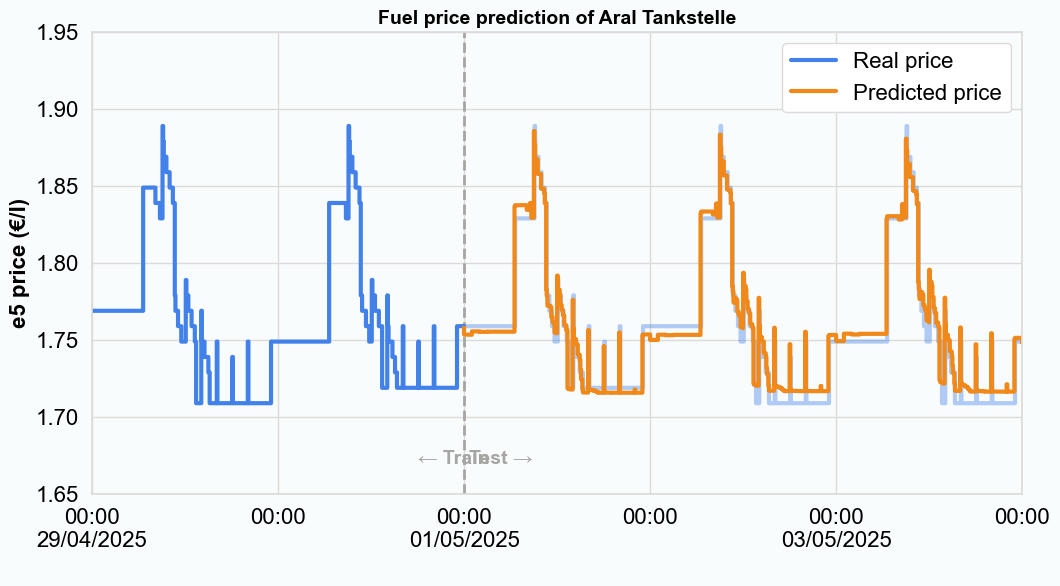

RMSE: 0.014
MAE: 0.009
R2: 0.894


In [18]:
# Print model results
params = {"background":"#f9fcfc",
          "gridcolor": "#dcdbd9",
          "legendedge": "#dcdbd9",
          "legendface": "white",
          "legendcol": "black",
          "textcolor": "black"
          }

print_model(df,pred,xlim=("2025-04-29","2025-05-04"),ylim=(1.65,1.95),params=params)

1-Day MAE in cent: 0.6030
3-Day MAE in cent: 0.7328
7-Day MAE in cent: 0.9406


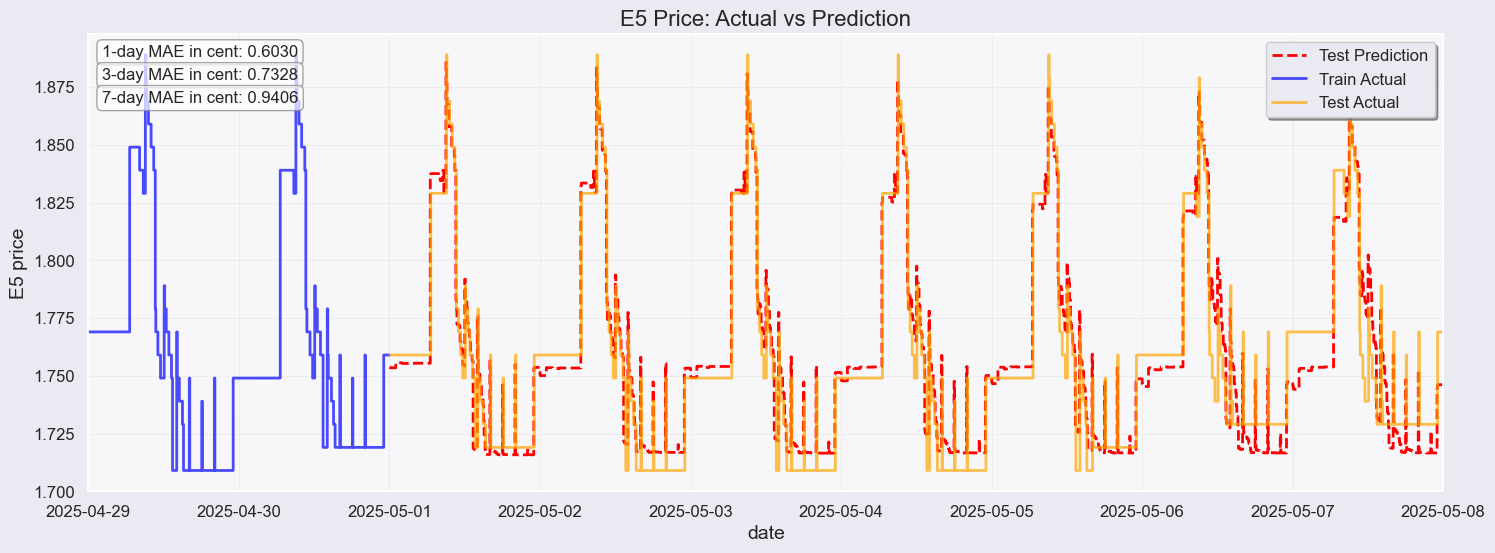

(0.006030285965379812,
 0.007327574464489578,
 0.009405623516065461,
 0.9273071200410831,
 0.9260272541202362,
 0.894279078310948)

In [24]:
forecast_freq = 5 # minutes, dicretization between individual values of the forcast
forecast_days = 7 # how many days should be forecasted
train_days = 30 # how many days will be used to train on
sampling_rate = 5 #in minutes, very important parameter


train_start = pd.to_datetime(train['datetime'].iloc[-1]) - pd.Timedelta(days = train_days)
train_end = pd.to_datetime(train['datetime'].iloc[-1])
# The forecast starts immediately after the training data ends
forecast_start_date = train_end + pd.Timedelta(minutes=forecast_freq)
# The forecast extends for 'forecast_days' from its start
forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=forecast_freq)
train_plot_start = pd.to_datetime(train['datetime'].iloc[-1]) - pd.Timedelta(days = 2)
train_plot_end = pd.to_datetime(train['datetime'].iloc[-1]) + pd.Timedelta(days = 1)

train_dates_plot = (train_plot_start.strftime('%Y-%m-%d'), train_plot_end.strftime('%Y-%m-%d'))
test_dates_plot = (forecast_start_date.strftime('%Y-%m-%d'), forecast_end_date.strftime('%Y-%m-%d'))



plot_forecast(df_train=train,
              df_test=test,
              station_uuid=None,
              df_train_prediction=None,
              df_test_prediction=pred,
              train_dates=train_dates_plot,
              test_dates=test_dates_plot,
              train_dates_plot=train_dates_plot,
              test_dates_plot=test_dates_plot
              )